# Enhanced Sentiment Analysis (Project B)

### Import libraries

In [ ]:
import numpy as np
import pandas as pd

import sklearn.linear_model
import sklearn.pipeline
from sklearn.utils import shuffle

# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

### Load Training Data

In [ ]:
import numpy as np
import pandas as pd
import os

data_dir = 'data_reviews'
x_train_df = pd.read_csv(os.path.join(data_dir, 'x_train.csv'))
y_train_df = pd.read_csv(os.path.join(data_dir, 'y_train.csv'))
x_test_df = pd.read_csv(os.path.join(data_dir, 'x_test.csv'))
our_test_x_df = pd.read_csv(os.path.join(data_dir, 'our_test_x.csv'))
our_test_y_df = pd.read_csv(os.path.join(data_dir, 'our_test_y.csv'))

### Changing text format (df to np)  

In [ ]:
text_col_arr =  x_train_df['text'].values
results_col_arr = np.ravel(y_train_df.values)

### Building a Custom Preprocessor

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Prepare a custom preprocessor to remove numbers
def custom_preprocessor(text):
  words = text.split()
  cleaned_words = []

  for word in words:
    cleaned_word = ''

    for char in word:
      if not char.isdigit():
        cleaned_word += char

    cleaned_words.append(cleaned_word)

  cleaned_text = " ". join(cleaned_words)
  return cleaned_text

def combined_preprocessor(text):
  text = CountVectorizer().build_preprocessor()(text)
  text = custom_preprocessor(text)
  return text


### Bag-of-Words Extraction

In [ ]:
# CountVectorizer configuration to analyze token frequencies
count_vectorizer = CountVectorizer(
    preprocessor=combined_preprocessor,
    min_df=5,  # Minimum document frequency
    max_df=0.1,  # Maximum document frequency
    ngram_range=(1, 1),  # N-gram range
)


# Fit and transform the text data using CountVectorizer
document_term_matrix = count_vectorizer.fit_transform(text_col_arr)

# Calculate the document frequency for each token
total_document_frequency = document_term_matrix.sum(axis=0)

# Convert the document frequency matrix to a list
document_frequency_list = total_document_frequency.tolist()[0]

# Create a dictionary mapping tokens to their document frequency
token_document_frequency_dict = dict(zip(count_vectorizer.get_feature_names_out(), document_frequency_list))

# Print the total number of tokens
total_tokens = len(token_document_frequency_dict)
print(f"Total Tokens: {total_tokens}")

# Print the document frequency for each token
for token, document_frequency in token_document_frequency_dict.items():
    print(f"Token: {token}, Document Frequency: {document_frequency}")


Total Tokens: 703
Token: about, Document Frequency: 70
Token: above, Document Frequency: 6
Token: absolutely, Document Frequency: 18
Token: acting, Document Frequency: 32
Token: action, Document Frequency: 6
Token: actor, Document Frequency: 7
Token: actors, Document Frequency: 17
Token: actually, Document Frequency: 14
Token: after, Document Frequency: 40
Token: again, Document Frequency: 40
Token: ago, Document Frequency: 6
Token: all, Document Frequency: 118
Token: almost, Document Frequency: 14
Token: also, Document Frequency: 57
Token: although, Document Frequency: 8
Token: always, Document Frequency: 16
Token: am, Document Frequency: 27
Token: amazing, Document Frequency: 29
Token: amazon, Document Frequency: 6
Token: amount, Document Frequency: 8
Token: an, Document Frequency: 91
Token: annoying, Document Frequency: 5
Token: another, Document Frequency: 18
Token: any, Document Frequency: 38
Token: anyone, Document Frequency: 21
Token: anything, Document Frequency: 13
Token: anyt

### Perform Grid Search

In [ ]:
# Create a pipeline for text classification
my_bow_classifier_pipeline = sklearn.pipeline.Pipeline([
    ('my_bow_feature_extractor', CountVectorizer(preprocessor=combined_preprocessor, min_df=1, max_df=0.09, ngram_range=(1, 1))),
    ('my_classifier', sklearn.linear_model.LogisticRegression(C=1.0, max_iter=1000, random_state=1)),
])

# Define a parameter grid for hyperparameter tuning
my_parameter_grid_by_name = dict()
my_parameter_grid_by_name['my_bow_feature_extractor__min_df'] = [5, 10, 15, 20, 80, 140, 160]
my_parameter_grid_by_name['my_bow_feature_extractor__max_df'] = [0.1, 0.2, 0.4, 0.8, 1.0]
my_parameter_grid_by_name['my_classifier__C'] = np.logspace(-4, 4, 9)

# Choose a scoring metric for model evaluation
my_scoring_metric_name = 'roc_auc'

# Create a KFold object for cross-validation with 10 folds
k_fold = sklearn.model_selection.KFold(n_splits=5, shuffle=True, random_state=0)

# Use GridSearchCV for hyperparameter tuning with cross-validation
grid_searcher = sklearn.model_selection.GridSearchCV(
    my_bow_classifier_pipeline,  # The model pipeline
    my_parameter_grid_by_name,  # The parameter grid to search
    scoring=my_scoring_metric_name,  # The evaluation metric
    cv=k_fold,  # 10-fold cross-validation
    refit=True,  # Refit the best model
    return_train_score=True # Receive training scores

)

# Shuffle the data before feeding it into the model
rand_text_col_arr, rand_results_col_arr = shuffle(text_col_arr, results_col_arr, random_state=1)

# Fit the grid search to find the best model and hyperparameters
grid_searcher.fit(rand_text_col_arr, rand_results_col_arr)


c:\Users\31618\envs\cs135_env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\31618\envs\cs135_env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('my_bow_feature_extractor',
                                        CountVectorizer(max_df=0.09,
                                                        preprocessor=<function combined_preprocessor at 0x00000152BD3011B0>)),
                                       ('my_classifier',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=1))]),
             param_grid={'my_bow_feature_extractor__max_df': [0.1, 0.2, 0.4,
                                                              0.8, 1.0],
                         'my_bow_feature_extractor__min_df': [5, 10, 15, 20, 80,
                                                              140, 160],
                         'my_classifier__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04])},
             return_train_score=True, scoring='roc_auc')

In [ ]:
cv_results_df = pd.DataFrame(grid_searcher.cv_results_)
print(cv_results_df)

file_path = "cv_results.csv"
cv_results_df.to_scv(file_path, index=False)

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.080491      0.030430         0.021048        0.009130   
1         0.066919      0.014789         0.018920        0.005985   
2         0.081261      0.019145         0.017391        0.002642   
3         0.072217      0.006253         0.014965        0.001848   
4         0.133173      0.047278         0.021149        0.004195   
..             ...           ...              ...             ...   
310       0.066359      0.005733         0.015327        0.000421   
311       0.077450      0.013788         0.018507        0.004777   
312       0.066034      0.003025         0.015271        0.000479   
313       0.065641      0.001551         0.017405        0.004316   
314       0.064310      0.000680         0.016207        0.002163   

    param_my_bow_feature_extractor__max_df  \
0                                      0.1   
1                                      0.1   
2                                

### HyperParameter Selection for Logistic Regression Classifier


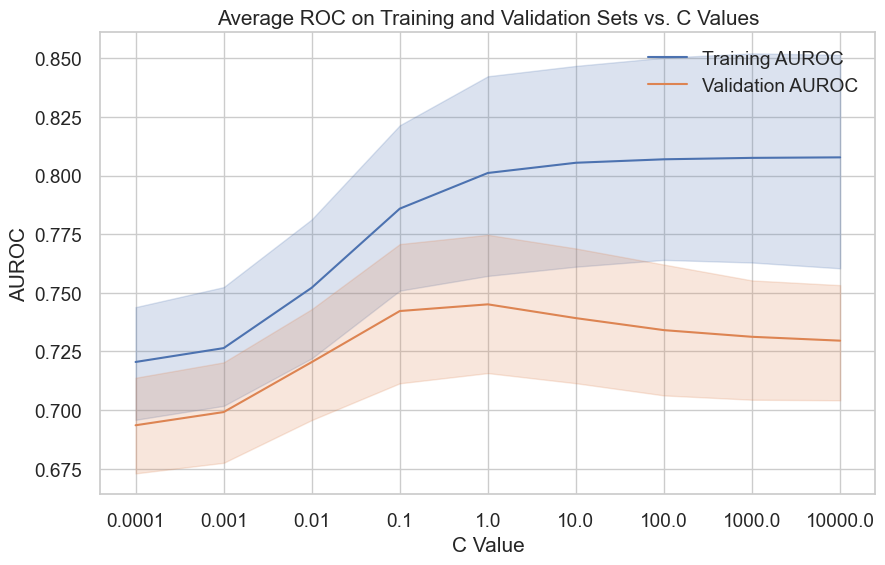

In [ ]:
# Extract the relevant data for 'my_classifier__C' hyperparameter
hyperparameter_values = grid_searcher.cv_results_['param_my_classifier__C']
mean_train_scores = grid_searcher.cv_results_['mean_train_score']
mean_test_scores = grid_searcher.cv_results_['mean_test_score']

# Save raw hyperparameter values
hyperparameter_values_str = hyperparameter_values.astype(str)

# Create a DataFrame for hyperparameter vs AUROC
df = pd.DataFrame({'C Value': hyperparameter_values_str,
                   'Train AUROC': mean_train_scores,
                   'Validation AUROC': mean_test_scores})

# Use Seaborn to create line plots
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x='C Value', y='Train AUROC', data=df, label='Training AUROC')
ax = sns.lineplot(x='C Value', y='Validation AUROC', data=df, label='Validation AUROC')

# Label the axes, title, and legend
plt.xlabel('C Value')
plt.ylabel('AUROC')
plt.title("Average ROC on Training and Validation Sets vs. C Values")
plt.legend()
plt.show()

# Across all combinations of max_df and min_df values, models that have the C value of 1.0 produce the best validation result.
# The blue and the orangelines are the average training and validation performance based on all combinations of max_df and min_df across all.


### Analysis of Predictions for the Best Classifier


Best Parameters: {'my_bow_feature_extractor__max_df': 0.1, 'my_bow_feature_extractor__min_df': 5, 'my_classifier__C': 1.0}
9
17


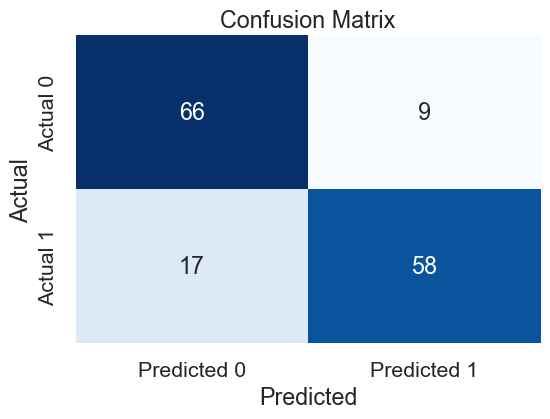

In [ ]:
import random
from sklearn.metrics import confusion_matrix


# Print best parameters
print('Best Parameters:', grid_searcher.best_params_)


# Prepare the the test data
our_test_x_arr =  our_test_x_df['text'].values
our_test_y_arr = np.ravel(our_test_y_df.values)

# Preprocess the x values
our_reprocessor = my_bow_classifier_pipeline.named_steps['my_bow_feature_extractor'].build_preprocessor()
our_preprocessed_test = [our_reprocessor(doc) for doc in our_test_x_arr]

# Predict the y values
best_model = grid_searcher.best_estimator_
model_test_y_arr = best_model.predict_proba(our_preprocessed_test)[:,1]


# Define a threshold for classification
threshold = 0.5

# Classify predictions using the threshold
predicted_labels = (model_test_y_arr > threshold).astype(int)


# Create the confusion matrix
confusion = confusion_matrix(our_test_y_arr, predicted_labels)


# Find the indices of false positives and false negatives

# true_positive_indicies = np.where((predicted_labels == 1) & (our_test_y_arr == 1))[0]
# true_negatives_indicies = np.where((predicted_labels == 0) & (our_test_y_arr == 0))[0]
false_positive_indices = np.where((predicted_labels == 1) & (our_test_y_arr == 0))[0]
false_negative_indices = np.where((predicted_labels == 0) & (our_test_y_arr == 1))[0]

# Create lists of false positives and false negatives

# true_positives = [our_test_x_arr[i] for i in true_positive_indicies]
# true_negatives = [our_test_x_arr[i] for i in true_negatives_indicies]
false_positives = [our_test_x_arr[i] for i in false_positive_indices]
false_negatives = [our_test_x_arr[i] for i in false_negative_indices]


# print(len(true_positives))
# print(len(true_negatives))
print(len(false_positives))
print(len(false_negatives))

# Plot the confusion matrix using seaborn
sns.set(font_scale=1.4)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Create a text file and write the sentences into it
with open('false_positives_and_negatives.txt', 'w', encoding='utf-8') as file:
    file.write("False Positives:\n")
    for fp in false_positives:
        if fp:
            file.write(fp + '\n')

    file.write("\nFalse Negatives:\n")
    for fn in false_negatives:
        if fn:
            file.write(fn + '\n')


# Analysis paragraph
# plt.figtext(0.1, -0.1, "Analysis: \n\n1. Sentence Length: \n2. Review Types: \n3. Negation Words:", fontsize=12)

# plt.show()

# # Produce the ROC Curve
# fpr, tpr, thresholds= sklearn.metrics.roc_curve(our_test_y_arr, model_test_y_arr)


# plt.plot(fpr, tpr, color ='b', lw=2, label='Best Model', linestyle='-.');

# plt.title("ROC on Test Set");
# plt.xlabel('false positive rate');
# plt.ylabel('true positive rate');
# plt.legend(loc='lower right');
# B = 0.01
# plt.xlim([0 - B, 1 + B]);
# plt.ylim([0 - B, 1 + B]);

### Performance on Test Set via Leaderboard


In [ ]:
# Retrieve the preprocessor
preprocessor = my_bow_classifier_pipeline.named_steps['my_bow_feature_extractor'].build_preprocessor()

# Use preprocessor on test data (for all lower tokens, no numbers, no punctuation)
test_text_col_arr = x_test_df['text'].values
preprocessed_test_data = [preprocessor(doc) for doc in test_text_col_arr]

# Use best model to make probabilistic predictions
best_model = grid_searcher.best_estimator_
test_prob_predictions = best_model.predict_proba(preprocessed_test_data)

# Get the probabilities for positive prediction
positive_prob = test_prob_predictions[:, 1]
print(positive_prob)


# Define the file path where you want to save the CSV file
file_path = 'yproba1_test.txt'

# Save the 'positive_prob' array as a CSV file
np.savetxt(file_path, positive_prob, delimiter=',', fmt='%s')

[4.98411211e-01 3.92240899e-01 2.47675845e-01 7.00495030e-02
 2.66025166e-01 6.67617453e-02 5.85981844e-02 1.11592264e-01
 1.36882682e-01 6.26727064e-01 4.44544220e-01 8.00194385e-01
 5.42212838e-02 1.38223952e-01 1.68551856e-01 8.06572431e-02
 2.68061679e-03 1.31675966e-01 3.79302584e-01 5.43536653e-01
 3.58049930e-01 4.74602676e-01 3.22009719e-01 3.36663720e-01
 4.52096793e-01 4.22818357e-01 2.40780166e-01 4.52501788e-01
 2.13926908e-01 2.75661143e-01 6.05830555e-01 3.48859038e-01
 2.54208944e-01 1.00992673e-02 2.80028969e-01 3.04821275e-01
 3.84305885e-01 1.58815896e-01 4.38360229e-01 3.52386637e-01
 7.63632087e-02 2.13926908e-01 4.49497985e-01 2.60960369e-01
 1.83458937e-01 9.07905260e-02 2.55500926e-01 7.56998455e-02
 9.42127724e-03 2.13926908e-01 1.29815711e-01 1.52042234e-01
 8.57827830e-01 4.61159633e-01 3.93217229e-01 2.31984364e-01
 1.43814774e-01 8.63210441e-02 6.15701905e-01 7.24098334e-02
 3.82066802e-01 1.16625279e-01 1.24255469e-01 7.28852636e-02
 1.01143506e-01 5.180338